## Analysis of shifts in a DFE of introgressed alleles over time

Analyses of trajectories of Neanderthal ancestry over time show an abrupt removal of much of the Neanderthal shortly (< 50 generations?) after the Neanderthal admixture. After this, the levels of Neanderthal ancestry in a population almost doesn't change at all.

One of the possible reasons for the quick flattening of the Nea. ancestry curve is the fact that selection was not able to remove introgressed Neanderthal alleles because the effective population size $N_e$ wasn't large enough.

In this notebook I'm trying to find out if there are some interesting patterns in the distribution of selection coefficients (_s_) of introgressed alleles over time that could reveal something about the process of selection against introgressed Neanderthal mutations.

I considered three models (example in the plot bellow):

* classic Gravel et al. demographic model
* model of a constant $N_e = 10000$
* model of an initial linear growth until $N_e = 10000$ followed by a period exponential growth

In [1]:
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(lazyeval))
suppressPackageStartupMessages(library(reshape2))

suppressPackageStartupMessages(source("../R/process_slim_output.R"))

Conflicts with tidy packages ---------------------------------------------------


In [2]:
traject_dir <- "../simulations/different_models"

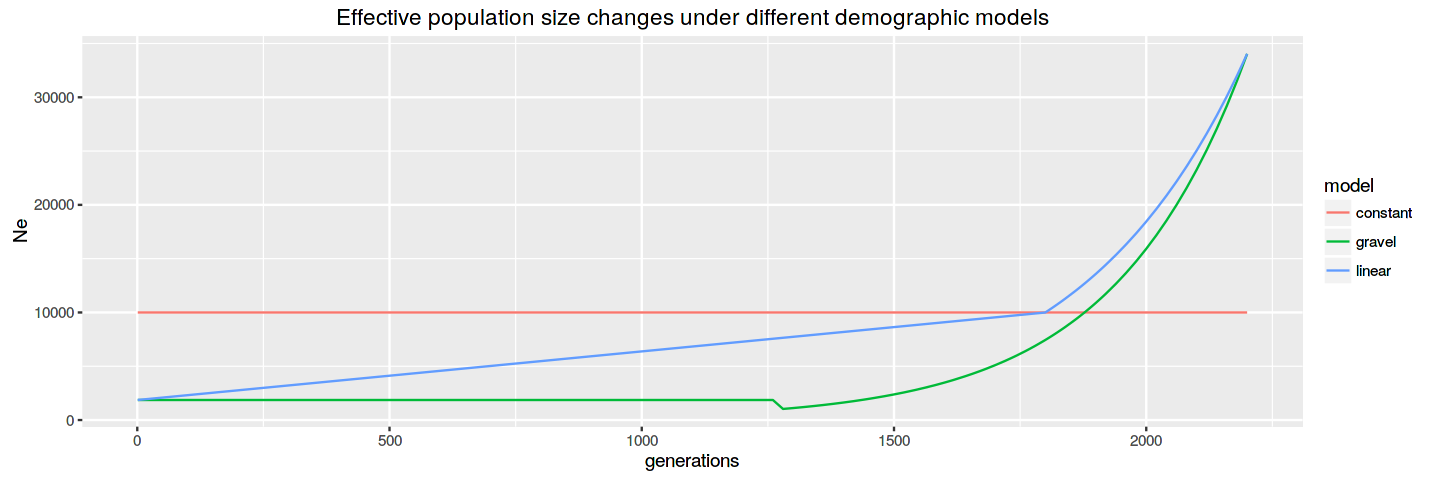

In [3]:
options(repr.plot.width=12, repr.plot.height=4)

# the custom SLiM output format includes a column with a Ne at each time-point
# this simply plots the values in this column for different simulation replicates
rbind(
    read.table(file.path(traject_dir, "constant__h_0.5__init_nea_0.1__rep_1__exonic_sites.txt"), header=TRUE) %>% mutate(model="constant"),
    read.table(file.path(traject_dir, "gravel__h_0.5__init_nea_0.1__rep_1__exonic_sites.txt"), header=TRUE)   %>% mutate(model="gravel"),
    read.table(file.path(traject_dir, "linear__h_0.5__init_nea_0.1__rep_1__exonic_sites.txt"), header=TRUE)   %>% mutate(model="linear")
) %>%
ggplot(aes(gen, Ne, color=model)) +
    geom_line() +
    labs(title="Effective population size changes under different demographic models",
         x="generations")

## Comparison of Neanderthal- and modern human-specific deleterious variants

Just a sanity check, I compared the DFE of Neanderthal-specific and modern-human specific mutations accumulated since the split between these two lineages (500 kya).

In [4]:
slim_file <- read_slim_file("../simulations/exome_and_sites__h_0.5__seed_6977220333793.txt")

Read mutations that occured on the Neanderthal lineage:

In [5]:
nea_mut <- read_mutations(slim_file, "m0", "p2") %>% mutate(count=freq, freq=count / (2 * 1000))

Read mutations that occured on the modern human lineage:

In [6]:
mh_mut <- read_mutations(slim_file, "m0", "p1", tmin=50000) %>% mutate(count=freq, freq=count / (2 * (10000 + 1861)))

Warning message:
“Removed 15 rows containing non-finite values (stat_ydensity).”Warning message in density.default(x, weights = w, bw = bw, adjust = adjust, kernel = kernel, :
“sum(weights) != 1  -- will not get true density”Warning message in density.default(x, weights = w, bw = bw, adjust = adjust, kernel = kernel, :
“sum(weights) != 1  -- will not get true density”

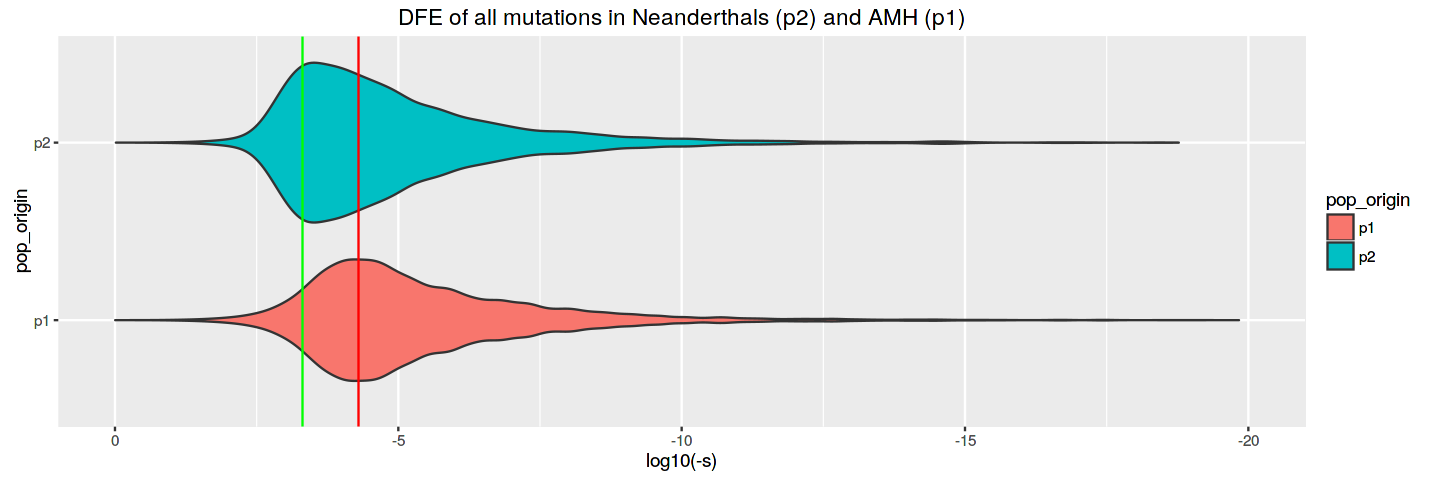

In [7]:
ggplot(rbind(mh_mut, nea_mut), aes(pop_origin, log10(-s), fill=pop_origin)) +
    geom_violin(aes(weight=freq)) +
    geom_hline(yintercept=log10(1/(2 * c(1000, 10000))), color=c("green", "red")) +
    coord_flip() +
    ylim(0, -20) +
    labs(title="DFE of all mutations in Neanderthals (p2) and AMH (p1)")

Warning message:
“Removed 15 rows containing non-finite values (stat_boxplot).”

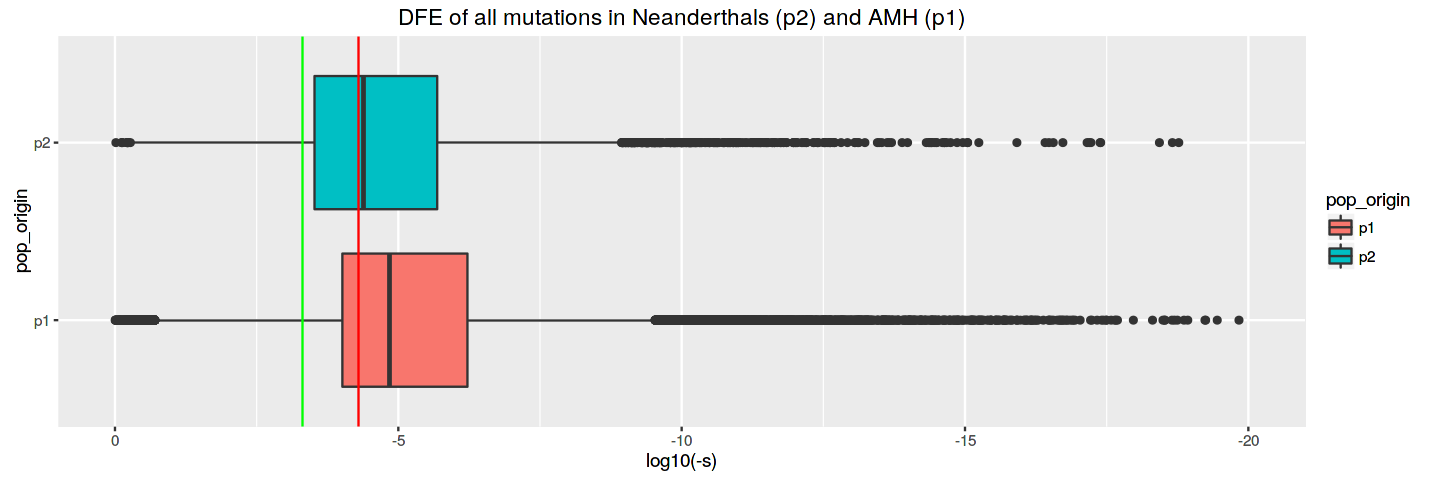

In [15]:
ggplot(rbind(mh_mut, nea_mut), aes(pop_origin, log10(-s), fill=pop_origin)) +
    geom_boxplot(aes(weight=freq)) +
    geom_hline(yintercept=log10(1/(2 * c(1000, 10000))), color=c("green", "red")) +
    coord_flip() +
    ylim(0, -20) +
    labs(title="DFE of all mutations in Neanderthals (p2) and AMH (p1)")

Warning message:
“Removed 28 rows containing non-finite values (stat_ydensity).”Warning message in density.default(x, weights = w, bw = bw, adjust = adjust, kernel = kernel, :
“sum(weights) != 1  -- will not get true density”Warning message in density.default(x, weights = w, bw = bw, adjust = adjust, kernel = kernel, :
“sum(weights) != 1  -- will not get true density”

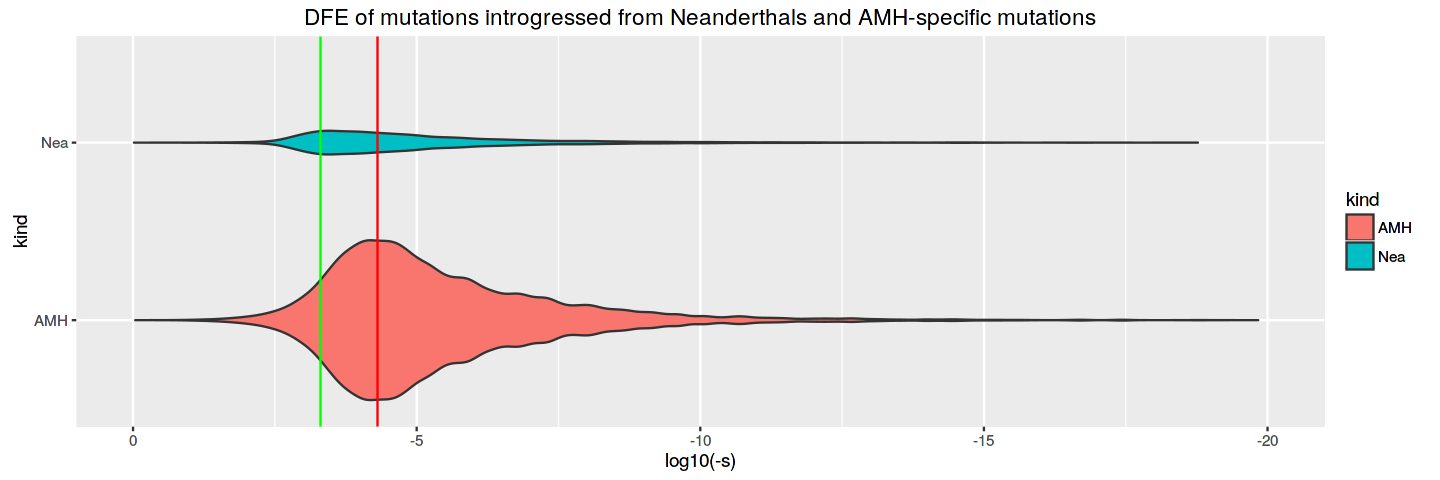

In [10]:
options(repr.plot.width=12, repr.plot.height=4)

ggplot(filter(dfes, gen == 1), aes(kind, log10(-s), fill=kind)) +
    geom_violin(aes(weight=freq)) +
    geom_hline(yintercept=log10(1/(2 * c(1000, 10000))), color=c("green", "red")) +
    coord_flip() +
    ylim(0, -20) +
    labs(title="DFE of mutations introgressed from Neanderthals and AMH-specific mutations")

Warning message:
“Removed 28 rows containing non-finite values (stat_boxplot).”

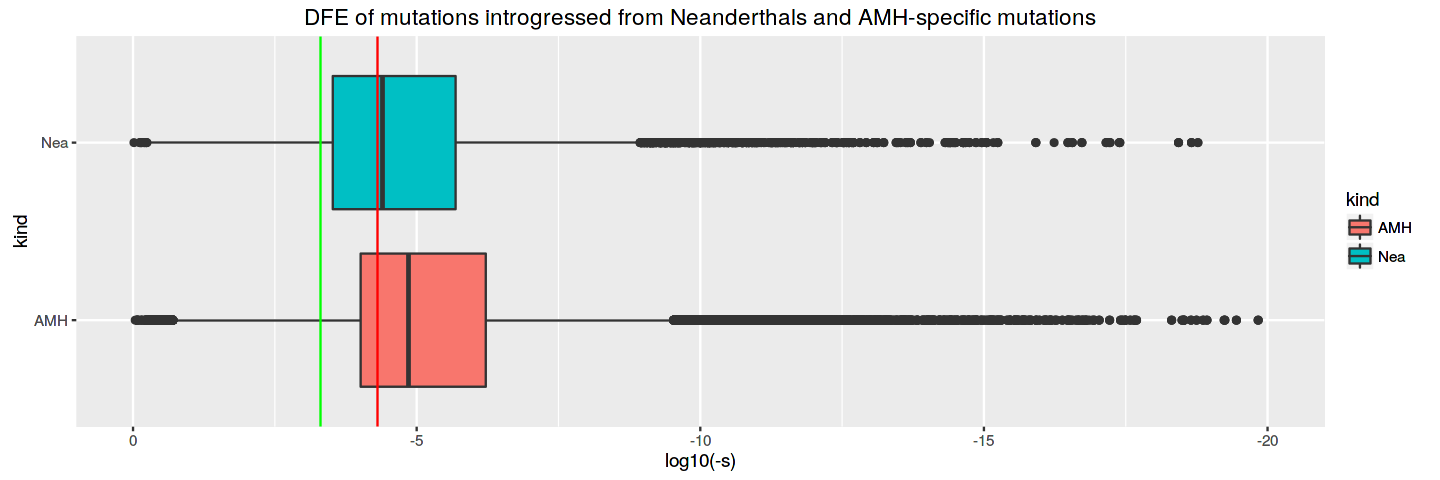

In [16]:
options(repr.plot.width=12, repr.plot.height=4)

ggplot(filter(dfes, gen == 1), aes(kind, log10(-s), fill=kind)) +
    geom_boxplot(aes(weight=freq)) +
    geom_hline(yintercept=log10(1/(2 * c(1000, 10000))), color=c("green", "red")) +
    coord_flip() +
    ylim(0, -20) +
    labs(title="DFE of mutations introgressed from Neanderthals and AMH-specific mutations")

The plot above clearly shows an excess of more weakly deleterious alleles in Neanderthals (p2) compared to modern humans (p1). This is consistent with the hypothesis of a less efficient purifying selection in the Neanderthal population.

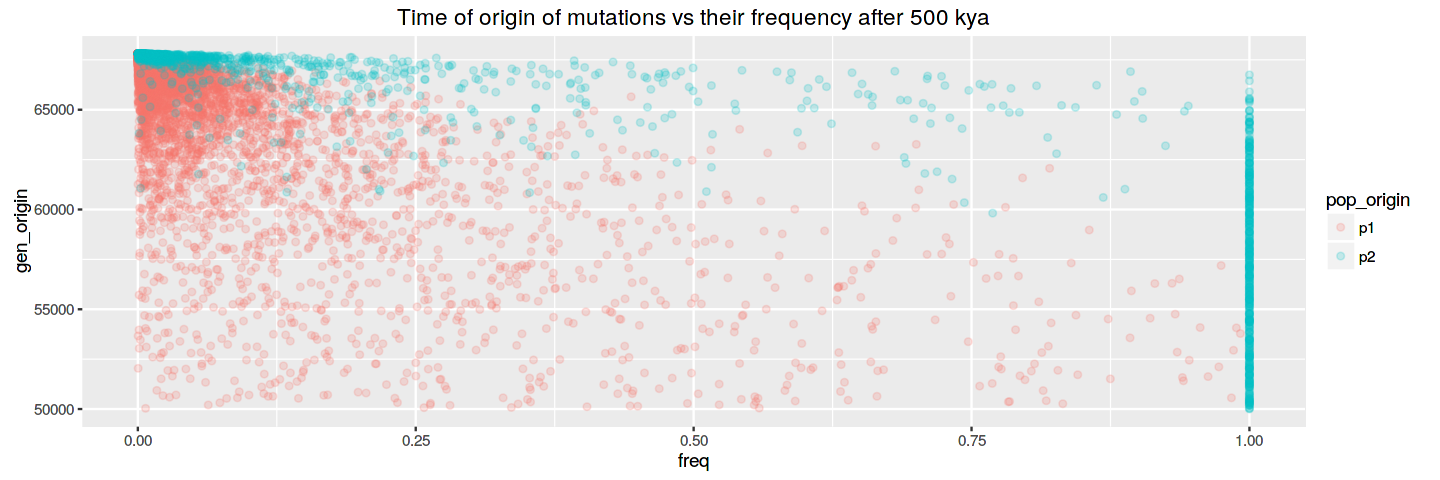

In [58]:
rbind(sample_frac(mh_mut, 0.2), sample_frac(nea_mut, 0.2)) %>%
ggplot(aes(x = freq, y = gen_origin, color=pop_origin)) +
    geom_point(alpha=0.2) +
    labs(title="Time of origin of mutations vs their frequency after 500 kya")

### Load the SLiM simulation output files for each model at different timepoints

This is a lot of data to parse (~57Gb), so we're going to do this in parallel.

In [59]:
library(parallel)

In [70]:
(gens <- c(1:50, seq(100, 2200, 300)))
(models <- c("constant", "linear", "gravel"))

[1]    1    2    3    4    5    6    7    8    9   10   11   12   13   14   15
[16]   16   17   18   19   20   21   22   23   24   25   26   27   28   29   30
[31]   31   32   33   34   35   36   37   38   39   40   41   42   43   44   45
[46]   46   47   48   49   50  100  400  700 1000 1300 1600 1900 2200

[1] "constant" "linear"   "gravel"

Load the exonic and nonexonic mutations in all specified generations for all three models:

In [63]:
combinations <- expand.grid(gen=gens, model=models)

In [9]:
dfes <- readRDS("../tmp/DFE.Rds")

In [67]:
dfes_list <-
    mclapply(
        1 : nrow(combinations),
        function(i) {
            model <- combinations[i, "model"]
            gen <- as.integer(combinations[i, "gen"])

            # load the whole SLiM output file first
            slim_file <- read_slim_file(file.path(traject_dir,
                                                  paste0(model,
                                                         "__h_0.5__init_nea_0.1__rep_1__dump_gen",
                                                         gen,
                                                         ".txt")))

            # get the Ne of modern humans in this generation
            N <- filter(read_populations(slim_file), pop_id == "p3")$pop_size

            # get info about the introgressed deleterious Nea. mutations
            # (anotate with the model, population origin, generation and frequency)
            nea_mut <-
                read_mutations(slim_file, "m0", "p2") %>%
                mutate(model=model, kind="Nea", gen=gen, freq=freq / (2 * N))

            # get info about the the "control" modern-human deleterious mutations
            # (anotate with the model, population origin, generation and frequency)
            control_mut <-
                read_mutations(slim_file, "m0", "p1", tmin=50000) %>%
                mutate(model=model, kind="AMH", gen=gen, freq=freq / (2 * N))

            # join both into a single dataframe and return it
            rbind(control_mut, nea_mut)
        },
        mc.cores=detectCores()
    )

In [68]:
dfes <- do.call(rbind, dfes_list) %>% mutate(gen=factor(gen))

In [74]:
saveRDS(dfes, "../tmp/DFE.Rds")

### Distribution of _s_ over time without weighting by the allele frequency

Warning message:
“Removed 753241 rows containing non-finite values (stat_boxplot).”

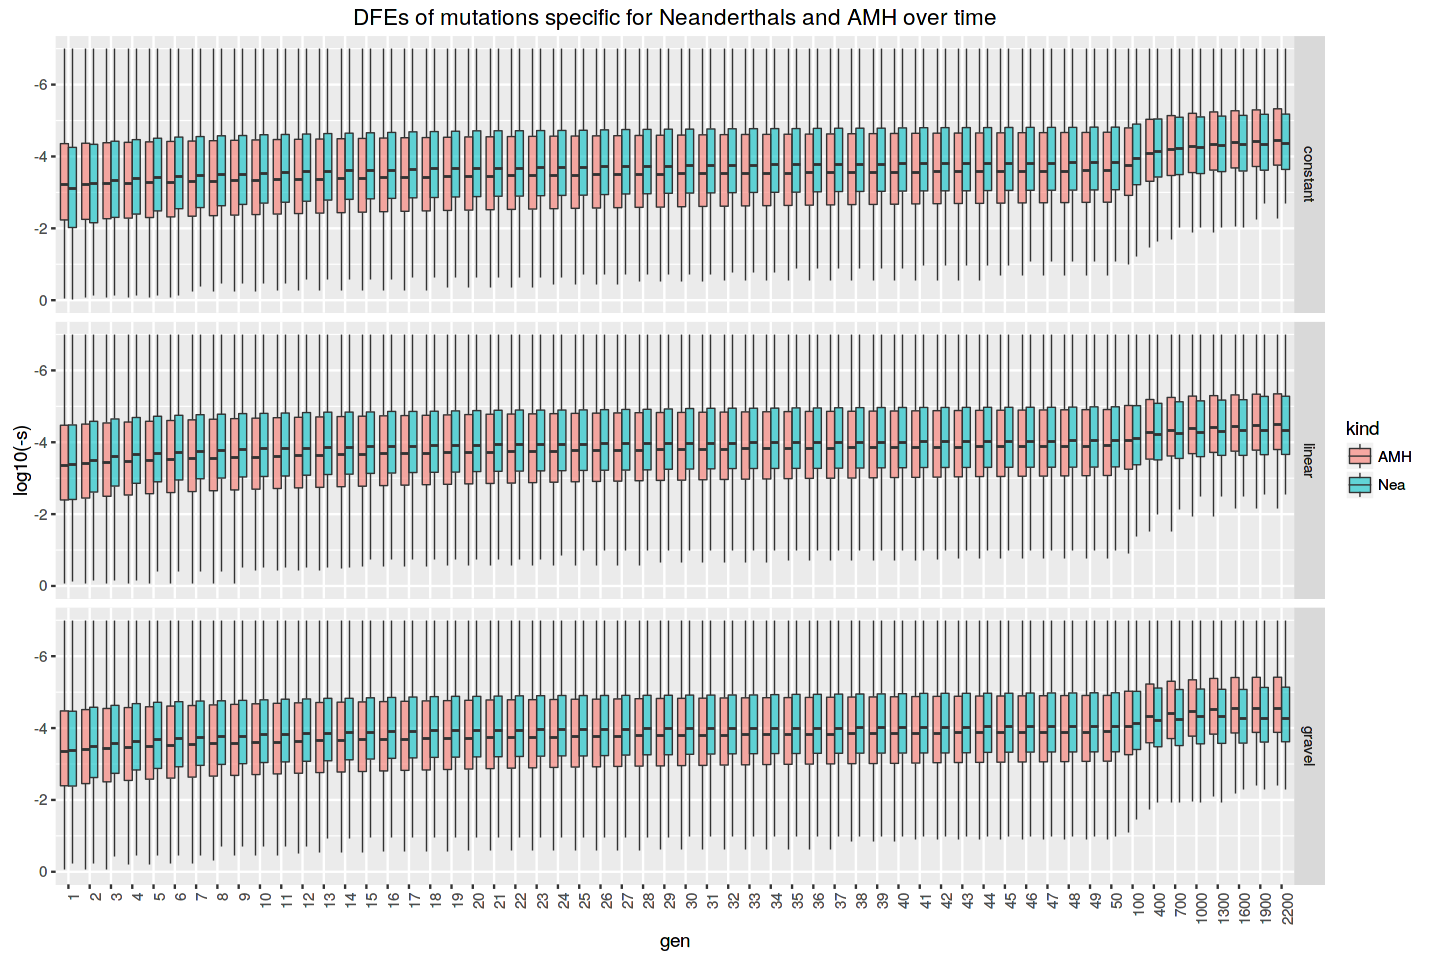

In [89]:
options(repr.plot.width=12, repr.plot.height=8)

ggplot(dfes, aes(x=gen, y=log10(-s))) +
    geom_boxplot(aes(fill=kind), alpha=0.6, outlier.shape=NA, size=0.3) +
    facet_grid(model ~ .) +
    ylim(0, -7) +
    labs(title="DFEs of mutations specific for Neanderthals and AMH over time") +
    theme(axis.text.x = element_text(angle=90, hjust=1))

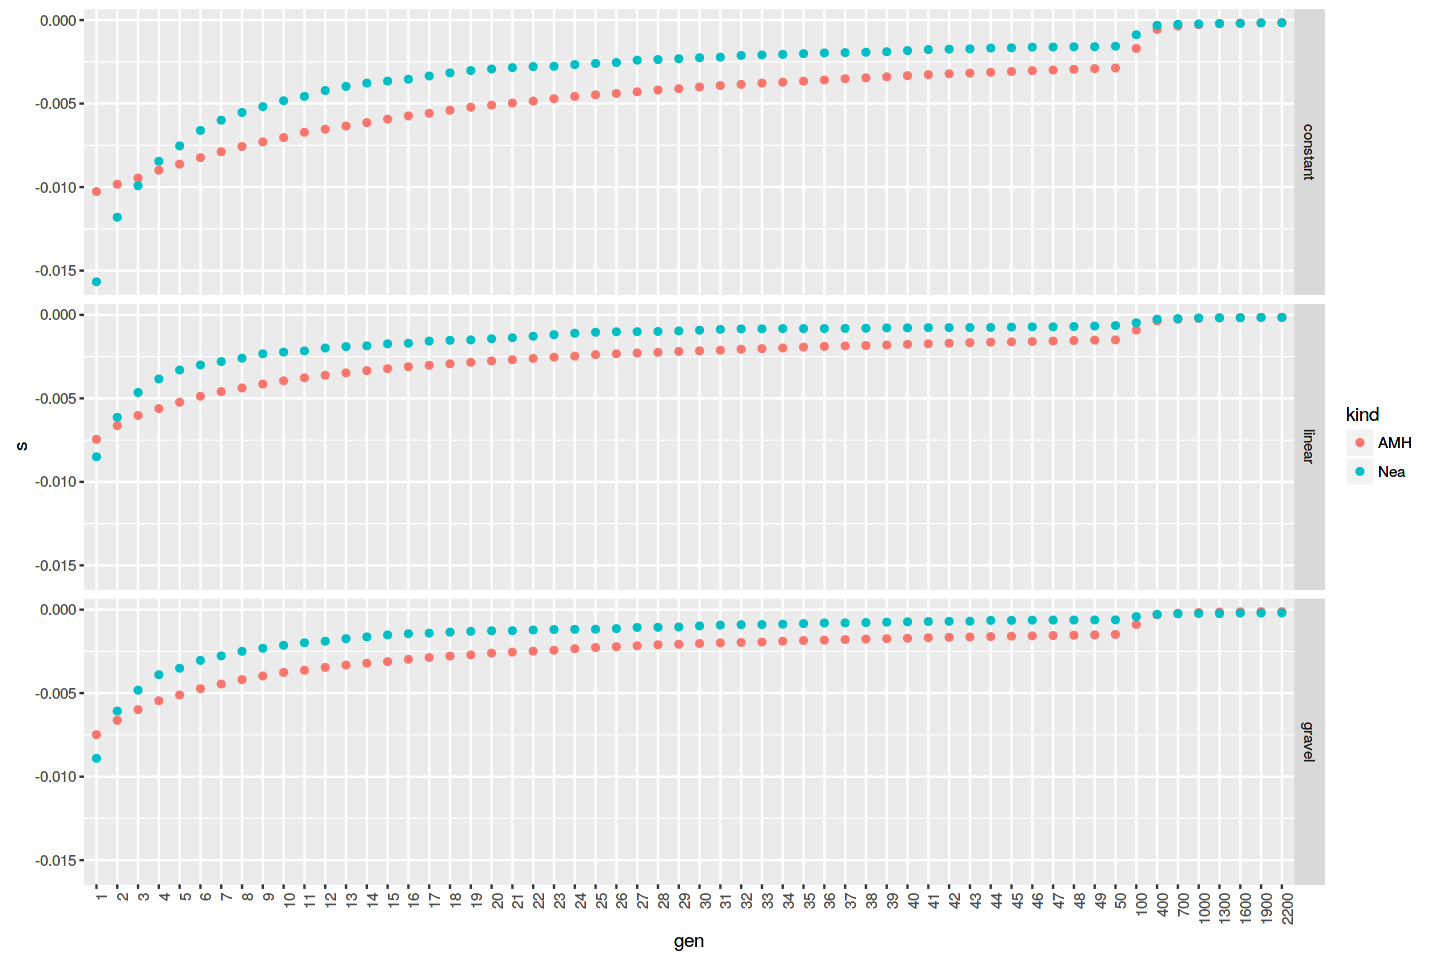

In [85]:
dfes %>%
group_by(model, kind, gen) %>%
#summarize(s=weighted.mean(s, freq)) %>%
summarize(s=mean(s)) %>%
ggplot(aes(gen, s, color=kind)) +
    geom_point() +
    facet_grid(model ~ .) +
    theme(axis.text.x = element_text(angle=90, hjust=1))

### Distribution of _s_ over time weighted by the allele frequency

Warning message:
“Removed 260692 rows containing non-finite values (stat_boxplot).”Warning message in rq.fit.br(wx, wy, tau = tau, ...):
“Solution may be nonunique”Warning message in rq.fit.br(wx, wy, tau = tau, ...):
“Solution may be nonunique”

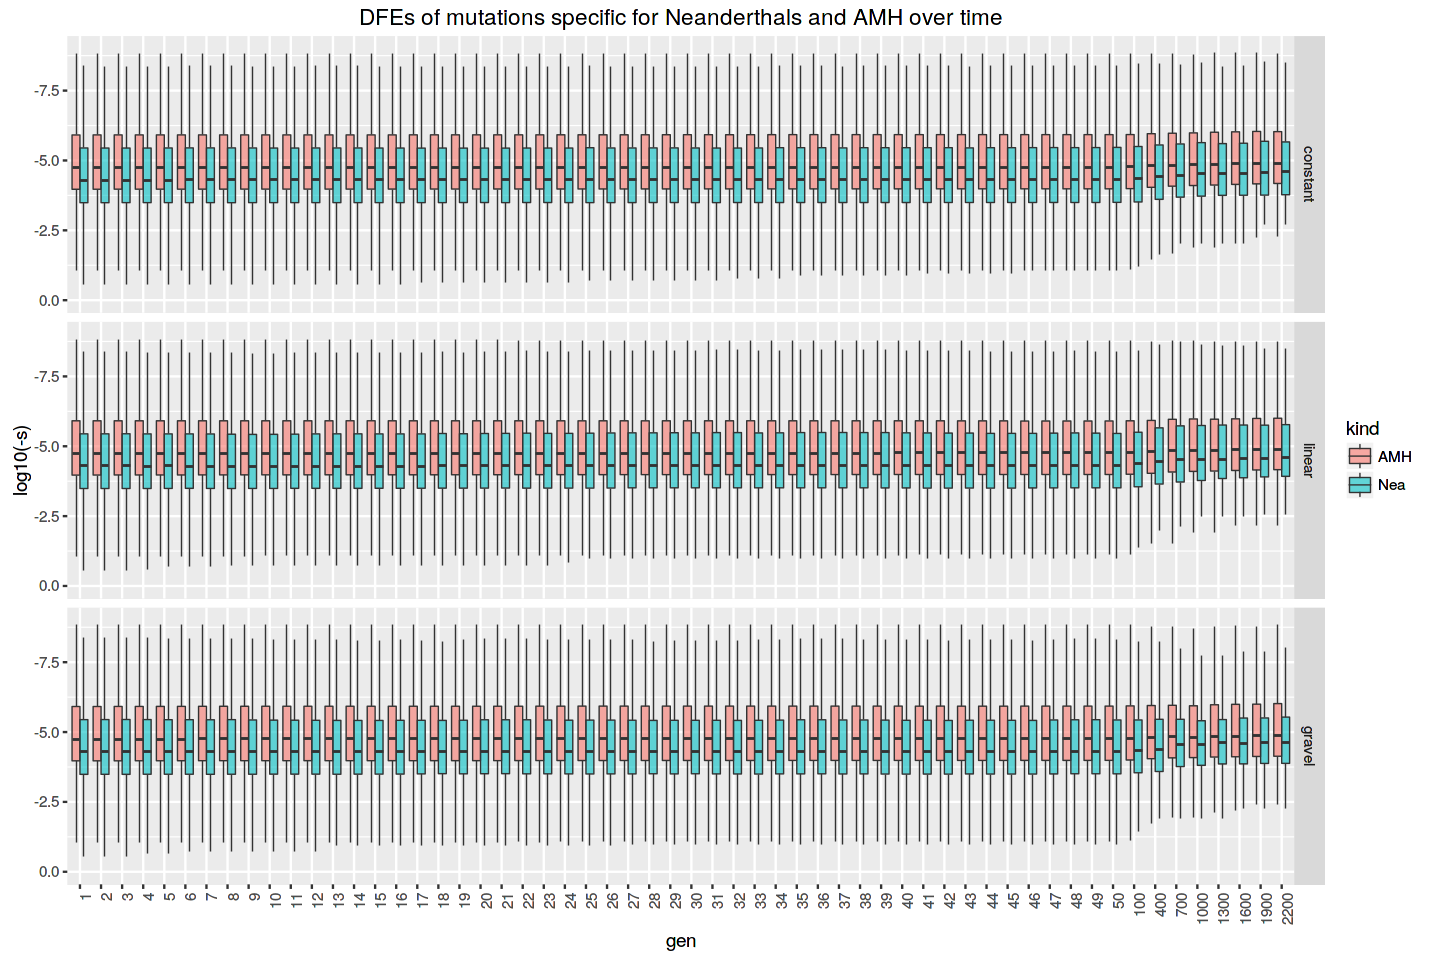

In [17]:
options(repr.plot.width=12, repr.plot.height=8)

ggplot(dfes, aes(x=gen, y=log10(-s))) +
    geom_boxplot(aes(fill=kind, weight=freq), alpha=0.6, outlier.shape=NA, size=0.3) +
    facet_grid(model ~ .) +
    ylim(0, -9) +
    labs(title="DFEs of mutations specific for Neanderthals and AMH over time") +
    theme(axis.text.x = element_text(angle=90, hjust=1))

Warning message:
“Removed 753241 rows containing non-finite values (stat_boxplot).”Warning message in rq.fit.br(wx, wy, tau = tau, ...):
“Solution may be nonunique”

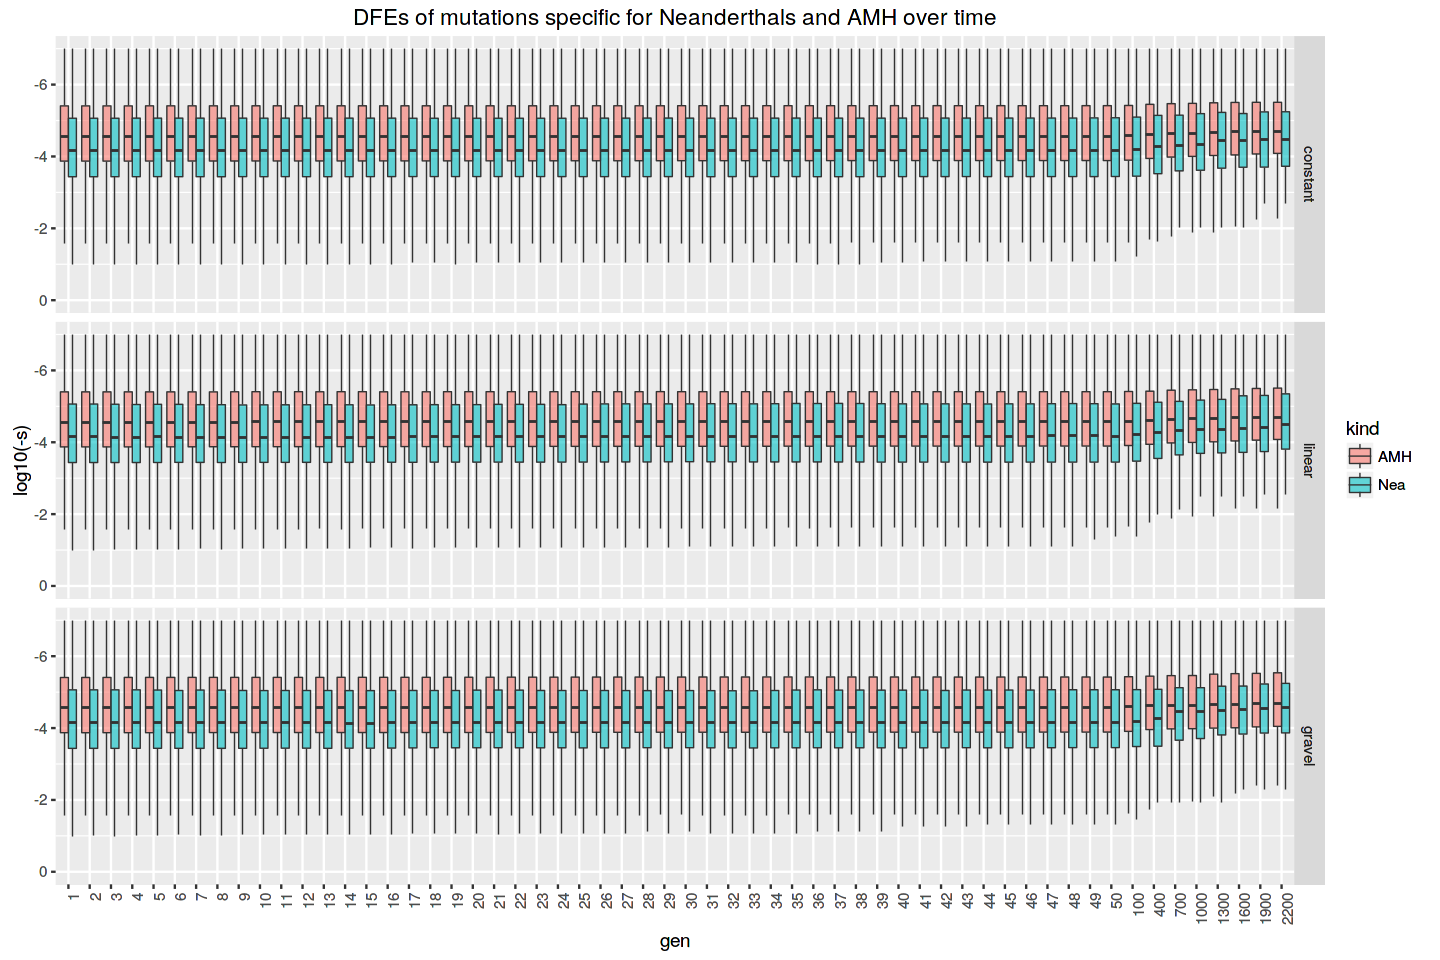

In [95]:
options(repr.plot.width=12, repr.plot.height=8)

ggplot(dfes, aes(x=gen, y=log10(-s))) +
    geom_boxplot(aes(fill=kind, weight=freq), alpha=0.6, outlier.shape=NA, size=0.3) +
    facet_grid(model ~ .) +
    ylim(0, -9) +
    labs(title="DFEs of mutations specific for Neanderthals and AMH over time") +
    theme(axis.text.x = element_text(angle=90, hjust=1))

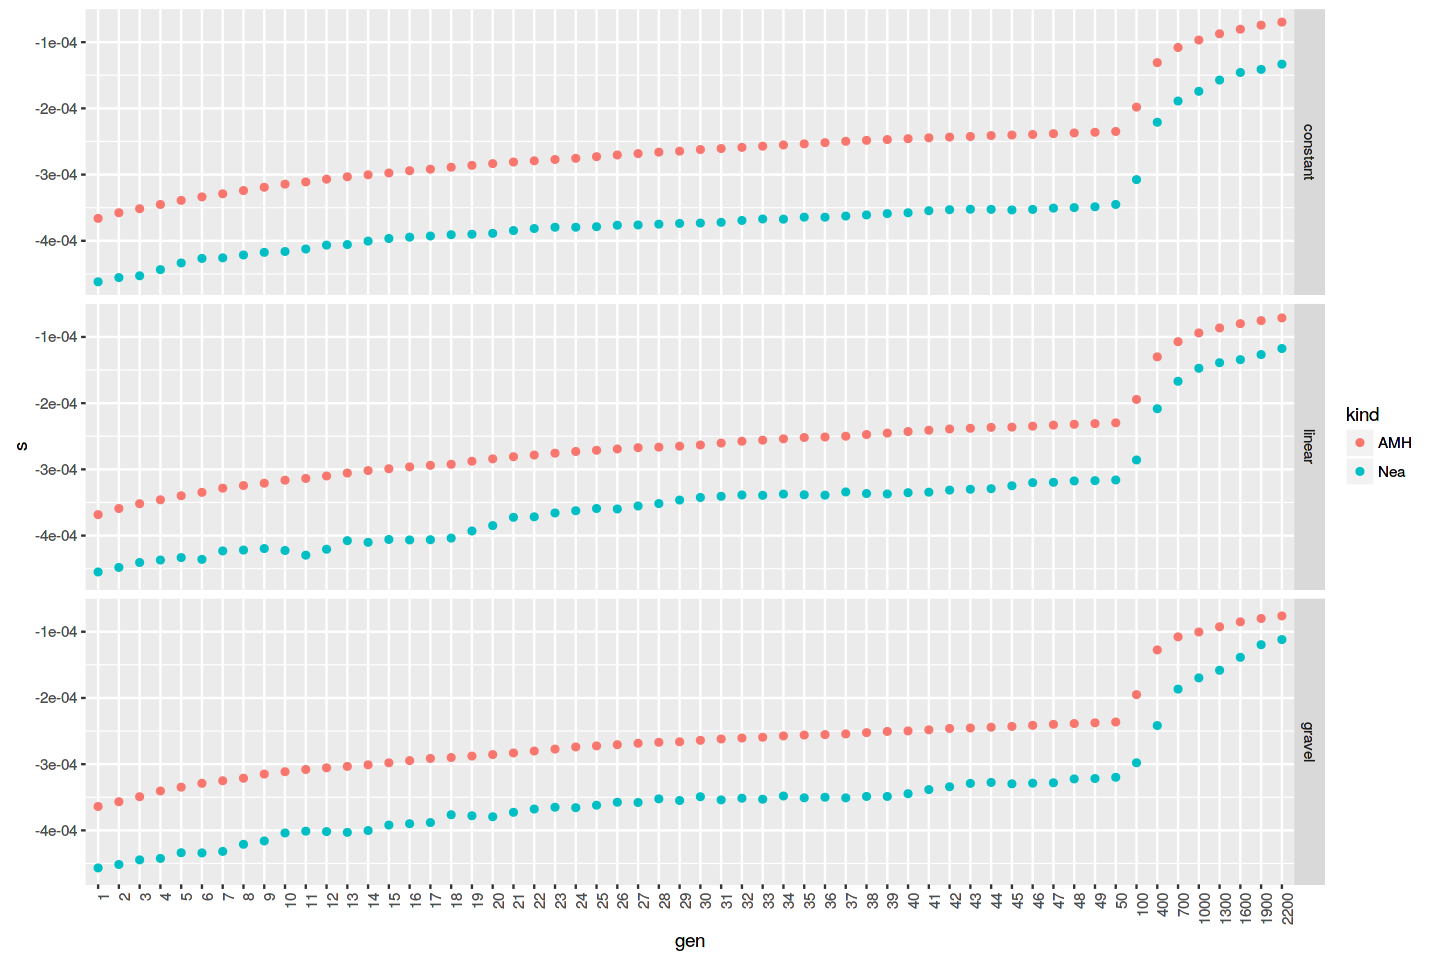

In [84]:
dfes %>%
group_by(model, kind, gen) %>%
summarize(s=weighted.mean(s, freq)) %>%
#summarize(s=mean(s)) %>%
ggplot(aes(gen, s, color=kind)) +
    geom_point() +
    facet_grid(model ~ .) +
    theme(axis.text.x = element_text(angle=90, hjust=1))

## Contribution to genetic load by Neanderthal and AMH-specific mutations

## Changes in _s_ of introgressed alleles through time

In [45]:
library(parallel)

In [46]:
(gens <- c(1:50, seq(100, 2200, 300)))

[1]    1    2    3    4    5    6    7    8    9   10   11   12   13   14   15
[16]   16   17   18   19   20   21   22   23   24   25   26   27   28   29   30
[31]   31   32   33   34   35   36   37   38   39   40   41   42   43   44   45
[46]   46   47   48   49   50  100  400  700 1000 1300 1600 1900 2200

In [47]:
dfes_list <- mclapply(gens, mc.cores=20, function(gen) {
    slim_file <- read_slim_file(paste0("../simulations/exonic_and_nonexonic/exonic_and_nonexonic__h_0.5__init_nea_0.1__rep_1__dump_gen", gen, ".txt"))
    N <- filter(read_populations(slim_file), pop_id == "p3")$pop_size
    # deleterious mutations originating in the Neanderthals
    introgr_mut <- read_mutations(slim_file, "m0", "p2") %>% mutate(kind="Nea",
                                                                    gen=gen,
                                                                    freq=freq / (2 * N))
    # "control" deleterious mutations originating in the ancestral African AMH population
    control_mut <- read_mutations(slim_file, "m0", "p1", t=50000) %>% mutate(kind="AMH",
                                                                      gen=gen,
                                                                      freq=freq / (2 * N))
    rbind(control_mut, introgr_mut)
})

In [62]:
dfes <- do.call(rbind, dfes_list) %>% mutate(gen=factor(gen))

Warning message:
“Removed 226454 rows containing non-finite values (stat_boxplot).”

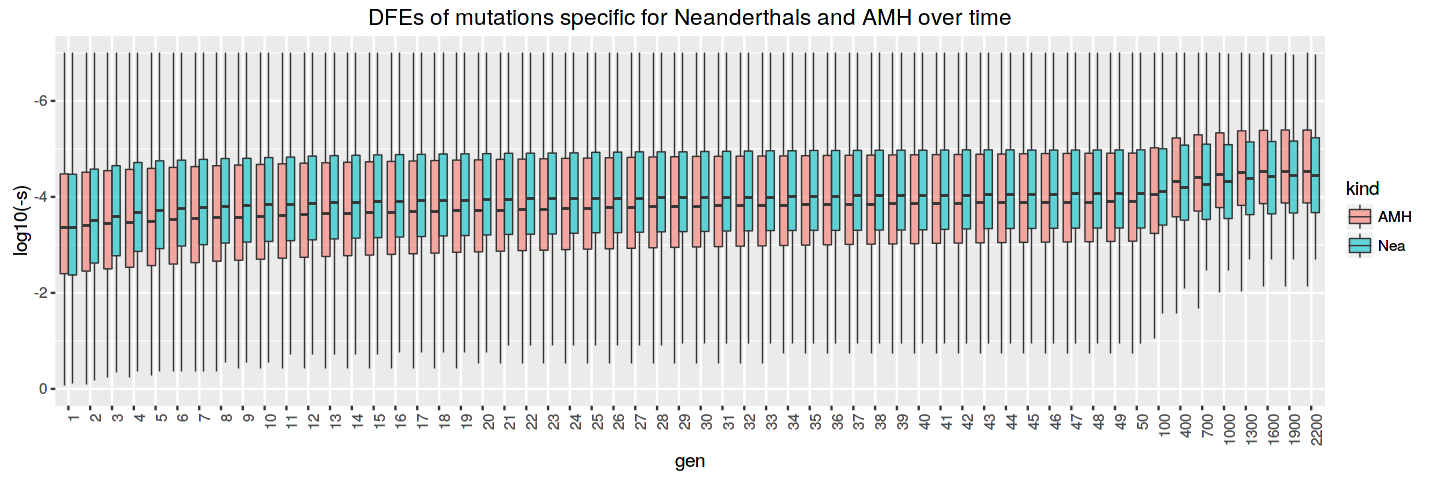

In [63]:
ggplot(dfes, aes(x=gen, y=log10(-s))) +
    geom_boxplot(aes(fill=kind), alpha=0.6, outlier.shape=NA, size=0.3) +
    ylim(0, -7) +
    labs(title="DFEs of mutations specific for Neanderthals and AMH over time") +
    theme(axis.text.x = element_text(angle = 90, hjust=1))

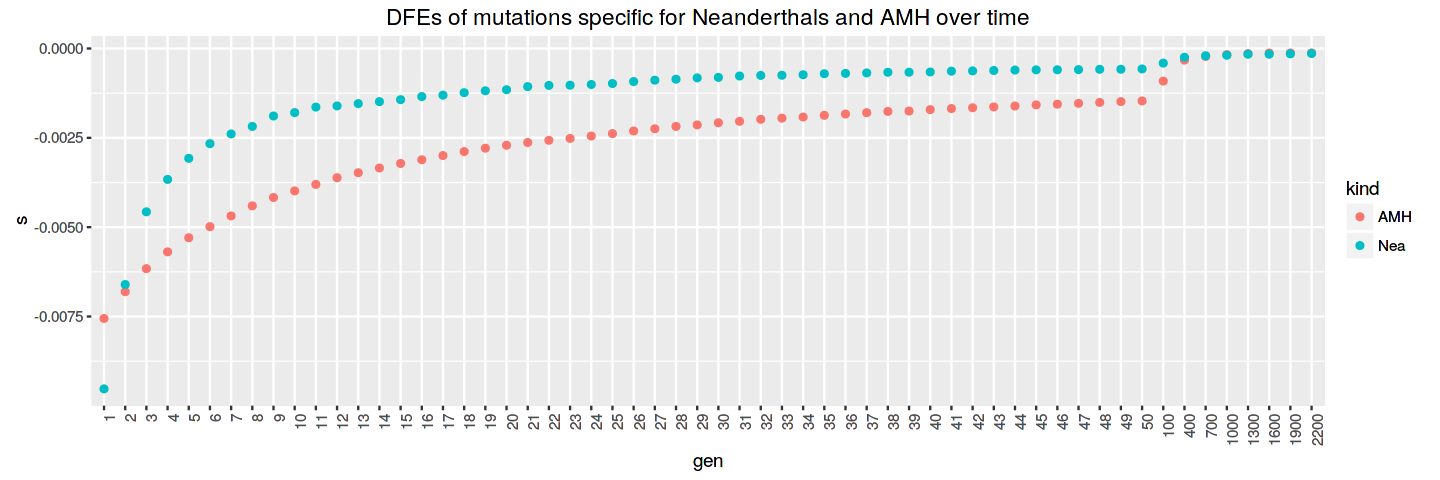

In [66]:
ggplot(group_by(dfes, gen, kind) %>% summarize(s=mean(s)), aes(x=gen, y=s, color=kind)) +
    geom_point() +
    labs(title="DFEs of mutations specific for Neanderthals and AMH over time") +
    theme(axis.text.x = element_text(angle = 90, hjust=1))

Nea. alleles sitting on haplotypes => faster change in DFE of introgressed alleles than non-introgressed (faster selection due to linkage?).